In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from nbodykit.lab import *

In [3]:
from h5py import File

In [4]:
f1 = File('/global/cscratch1/sd/yfeng1/baoshift-hdf5/00000600-40-now/fof_0.6250.hdf5')

In [5]:
list(f1.keys())

['FOFGroups']

In [76]:
pos = f1['FOFGroups']['Position'][:]
vel = f1['FOFGroups']['Velocity'][:]
mass = f1['FOFGroups']['Length'][:] * 27.75e10 * 0.3 * (1380 / 2048.) ** 3

In [90]:
posrandom = numpy.random.uniform(size=(100000, 3))

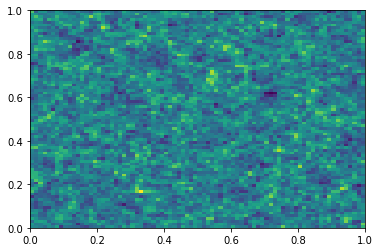

In [8]:
_ = hist2d(pos[:, 0], pos[:, 1], bins=80)

In [10]:
from nbodykit.cosmology import Planck15 

In [12]:
Planck15.comoving_distance(0.5)

1317.926097894893

In [28]:
from numpy import arcsin, arctan2, pi
def pos2radec(pos, obs):
    x, y, z= (pos - obs).T
    r = (x**2+y**2+z**2) ** 0.5
    dec = arcsin(z / r)
    ra = arctan2(y, x)
    return ra, dec, r   

In [29]:
ra, dec, r = pos2radec(pos, [.5, .5, .5])

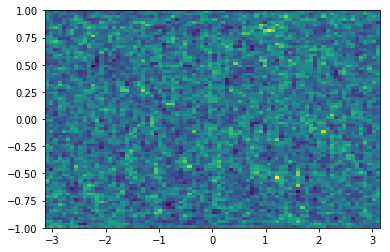

In [34]:
_ = hist2d(ra[r < 0.5], sin(dec[r < 0.5]), bins=80)

In [35]:
from scipy.interpolate import UnivariateSpline

In [38]:
from nbodykit.cosmology import Planck15

In [41]:
Planck15.comoving_distance?

In [42]:
def r2z(cosmology, r1):
    zgrid = numpy.linspace(0, 9.0, 10000)
    rgrid = cosmology.comoving_distance(zgrid)
    spl = UnivariateSpline(rgrid, zgrid)
    return spl(r1)

In [81]:
z = r2z(Planck15, r * 1380.)

In [77]:
import healpy
import numpy
class DESIFootprint:
    def __init__(self, desi_map):
        map = healpy.read_map('/project/projectdirs/desi/mocks/GaussianRandomField/v0.0.4/desi-map.fits')
        self.map = map
        
    def f(self, ra, dec):
        pix = healpy.ang2pix(nside=32, phi=ra, theta=numpy.pi / 2 - dec)
        return self.map[pix]

In [78]:
ftp = DESIFootprint('/project/projectdirs/desi/mocks/GaussianRandomField/v0.0.4/desi-map.fits')

NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [101]:
class Mock:
    def __init__(self, pos, cosmo, ftp, obs):
        ra, dec, r = pos2radec(pos, obs=obs)
        z = r2z(cosmo, r)
        f = ftp.f(ra, dec)
        self.ra = ra
        self.dec = dec
        self.z = z
        self.f = f

In [102]:
data = Mock(pos * 1380, Planck15, ftp, obs=[690, 690, 690])
random = Mock(posrandom * 1380, Planck15, ftp, obs=[690, 690, 690])

In [66]:
Planck15.comoving_distance([0, 0.6, 1.0, 1.5, 2, 2.5])

array([    0.        ,  1538.85760838,  2300.39593014,  3034.12174691,
        3598.05878546,  4045.27774763])

In [103]:
lowmass = (data.z < 0.3) & (data.f > 0.2) & (mass < 1e13)
highmass =  (data.z < 0.3) & (data.f > 0.2) & (mass > 1e13)

In [104]:
randommask = (random.z < 0.3) & (random.f > 0.2)

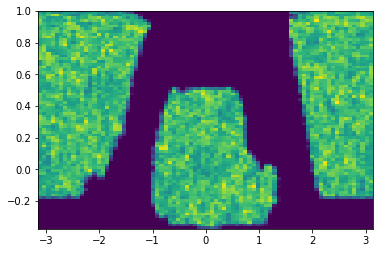

In [106]:
_ = hist2d(data.ra[lowmass], sin(data.dec[lowmass]), bins=80)

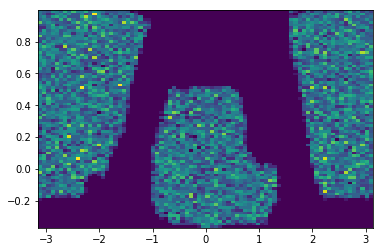

In [107]:
_ = hist2d(random.ra[randommask], sin(random.dec[randommask]), bins=80)

In [122]:
from kdcount.sphere import AngularBinning
from kdcount.sphere import points
from kdcount.correlate import paircount

In [121]:
ds_lowmass = points(np.degrees(data.ra[lowmass]), np.degrees(data.dec[lowmass]))

In [123]:
bins = AngularBinning(linspace(0, 2.0, 20))

In [125]:
#r = paircount(ds_lowmass, ds_lowmass, bins)

In [ ]:
data.ra[lowmass], data.dec[lowmass]

In [ ]:
healpy.anafast()

In [109]:
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks

In [110]:
bins = linspace(0, 10, 20)

In [117]:
data.dec.max()

1.5703278728561878

In [120]:
#DDtheta_mocks(1, 1, bins, np.degrees(data.ra[lowmass]+ pi), np.degrees(data.dec[lowmass]), verbose=True, )